In [40]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions, BenchmarkTools

In [41]:
includet("../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [42]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

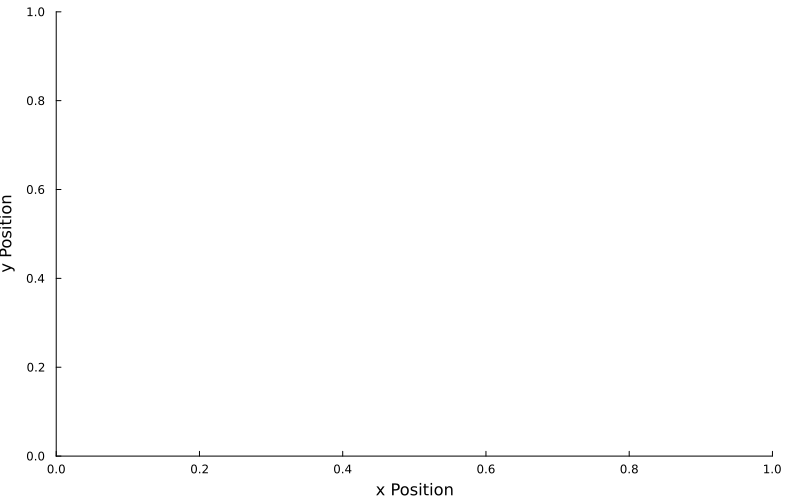

In [43]:
# Define the plot
num_points = 64

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / num_points for j in 0:num_points, i in 0:num_points]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / num_points for j in 0:num_points, i in 0:num_points]

grid = range(0, stop=1, length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = heatmap(xlims=domain[1], ylims=domain[2], xlabel="x Position", ylabel="y Position", color=:viridis, colorbar_title="Amplitude", size=plot_size, grid=false)

In [44]:
ops = gaussian_operators_2D(0.05, plt_grid_x1, plt_grid_x2)

Operators(var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}(var"#gauss2D#28"{Matrix{Float64}, Float64}([0.0 0.0; 0.0 0.015625; … ; 1.0 0.984375; 1.0 1.0], 399.99999999999994), 4225), var"#Φ#30"{var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}}(var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}(var"#gauss2D#28"{Matrix{Float64}, Float64}([0.0 0.0; 0.0 0.015625; … ; 1.0 0.984375; 1.0 1.0], 399.99999999999994), 4225)), var"#adjΦ#31"{Matrix{Float64}, Matrix{Float64}, var"#adjΦ#27#32"{var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}}}([0.0 0.015625 … 0.984375 1.0; 0.0 0.015625 … 0.984375 1.0; … ; 0.0 0.015625 … 0.984375 1.0; 0.0 0.015625 … 0.984375 1.0], [0.0 0.0 … 0.0 0.0; 0.015625 0.015625 … 0.015625 0.015625; … ; 0.984375 0.984375 … 0.984375 0.984375; 1.0 1.0 … 1.0 1.0], var"#adjΦ#27#32"{var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}}(var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}(var"#gauss2D#28"{Matrix{Float6

## Pre-certificate

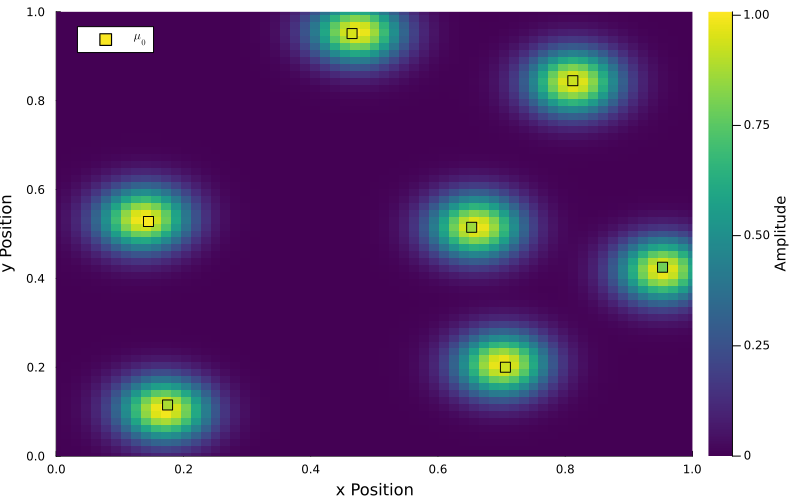

In [45]:
x0 = [
    [0.145, 0.175, 0.465, 0.706, 0.653, 0.953, 0.812],
    [0.528, 0.115, 0.951, 0.200, 0.515, 0.425, 0.845]
]
a0 = [1.000, 0.88, 0.947, 0.929, 0.857, 0.788, 0.927]

# x0 = [[0.5], [0.5]]
# a0 = [1.0]

μ0 = DiscreteMeasure(x0, a0)

ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, grid, grid, ηV, color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=1)

In [46]:
maximum(abs.(ηV))

1.0077743725021198

### SFW

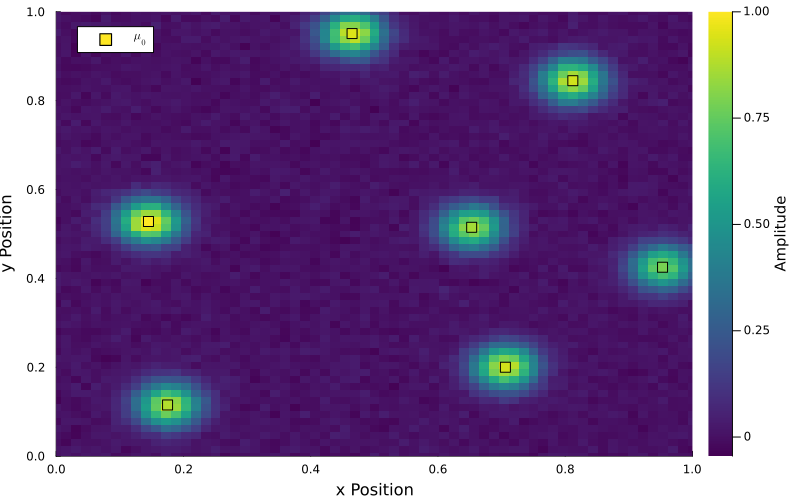

In [47]:
y0 = ops.Φ(μ0...)

function add_noise(y0, noise_level)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 0.1
Random.seed!(1)
y = add_noise(y0, noise_level)

plt_obs = deepcopy(plt)

heatmap!(plt_obs, grid, grid, reshape(y, size(plt_grid_x1)), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=1)

In [48]:
λ = 8noise_level

0.8

BFGS on L1 norm

| Iteration | Lasso time | Lasso gc  | Lasso compile | LD time  | LD gc   | LD compile  |
|-----------|------------|-----------|---------------|----------|---------|-------------|
| 1         | 0.0715     | 0.0165    | 0.0           | 0.0285   | 0.0058  | 0.0         |
| 2         | 0.1789     | 0.0437    | 0.0           | 0.0411   | 0.0083  | 0.0         |
| 3         | 0.1078     | 0.028     | 0.0           | 0.0857   | 0.0177  | 0.0         |
| 4         | 0.1368     | 0.0287    | 0.0           | 0.1675   | 0.0374  | 0.0         |
| 5         | 0.1109     | 0.0202    | 0.0           | 0.3041   | 0.0649  | 0.0         |
| 6         | 0.2936     | 0.0576    | 0.0           | 0.4688   | 0.0906  | 0.0         |
| 7         | 0.3124     | 0.0557    | 0.0           | 0.6841   | 0.1333  | 0.0         |
| 8         | 0.3791     | 0.0681    | 0.0           | 1.9415   | 0.3732  | 0.0         |
| 9         | 0.2619     | 0.0446    | 0.0           | 6.8208   | 1.2402  | 0.0         |


DiscreteMeasure([[0.7109374999999994, 0.14559052630115715, 0.8119147345767096, 0.46465457554682205, 0.6524231631393262, 0.17566442499367904, 0.9528775437089051, 0.7097948327860366, 0.6953125000000012], [0.20210331075086801, 0.5275721102869694, 0.8453628603925323, 0.9506290369211575, 0.514902085104671, 0.11541557287395869, 0.4257354956732072, 0.21371181321533925, 0.19531250000000006]], [0.575423891442959, 0.9444656721422994, 0.8784411360445775, 0.8936514073274043, 0.8082222920852681, 0.8261057427708075, 0.7368242978473383, 1.1059025253217113e-12, 0.2948829038080846], 2, 9)

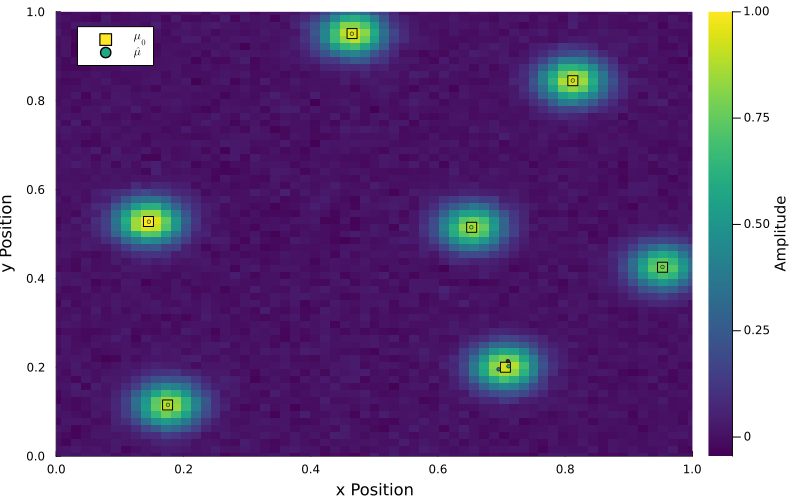

In [49]:
prob = BLASSO(y, ops, domain, λ)
solve!(prob, options=Dict(:maxits => length(a0) + 3, :positivity => false))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)

LBFGS

| Iteration | Lasso time | Lasso gc  | Lasso compile | LD time  | LD gc   | LD compile  |
|-----------|------------|-----------|---------------|----------|---------|-------------|
| 1         | 0.0559     | 0.013     | 0.0           | 0.0142   | 0.0028  | 0.0         |
| 2         | 0.162      | 0.0354    | 0.0           | 0.0461   | 0.0084  | 0.0         |
| 3         | 0.0908     | 0.0194    | 0.0           | 0.1159   | 0.0219  | 0.0         |
| 4         | 0.1506     | 0.0342    | 0.0           | 0.4172   | 0.0897  | 0.0         |
| 5         | 0.1051     | 0.0214    | 0.0           | 0.528    | 0.1128  | 0.0         |
| 6         | 0.3469     | 0.0629    | 0.0           | 1.1695   | 0.2307  | 0.0         |
| 7         | 0.2346     | 0.0427    | 0.0           | 1.5584   | 0.3045  | 0.0         |
| 8         | 0.3625     | 0.0656    | 0.0           | 8.2302   | 1.5795  | 0.0         |
| 9         | 0.6071     | 0.114     | 0.0           | 9.167    | 1.7499  | 0.0         |


DiscreteMeasure([[0.5943410509959017, 0.1455908914144161, 0.8119145609548681, 0.4646556292249819, 0.652423315950584, 0.17566469920755218, 0.9528794418298108, 0.7109374999999996, 0.6953125000000006], [0.24756345003203278, 0.5275751018897084, 0.8453626403185642, 0.9506290196644116, 0.514900984359216, 0.11541528392357665, 0.4257365958262516, 0.2020920904630876, 0.1953125000000011]], [6.321735454122695e-15, 0.9444713246072998, 0.878444984188742, 0.8936454409524373, 0.8082203838179791, 0.8261111685401745, 0.7368136013869435, 0.5764544953344202, 0.293898810191346], 2, 9)

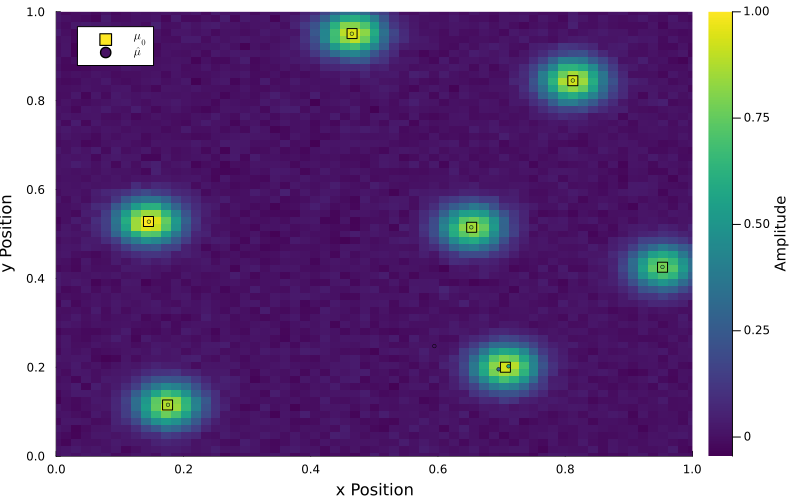

In [63]:
prob = BLASSO(y, ops, domain, λ)
solve!(prob, options=Dict(:maxits => length(a0) + 3, :descent => :LBFGS, :positivity => true))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)

Smooth bilevel

| Iteration | Lasso time | Lasso gc  | Lasso compile | LD time  | LD gc   | LD compile  |
|-----------|------------|-----------|---------------|----------|---------|-------------|
| 1         | 0.0553     | 0.0133    | 0.0           | 0.0151   | 0.0024  | 0.0         |
| 2         | 0.2055     | 0.0451    | 0.0           | 0.048    | 0.0077  | 0.0         |
| 3         | 0.1017     | 0.0219    | 0.0           | 0.1294   | 0.03    | 0.0         |
| 4         | 0.1392     | 0.0273    | 0.0           | 0.2393   | 0.0542  | 0.0         |
| 5         | 0.1174     | 0.0216    | 0.0           | 0.3652   | 0.0747  | 0.0         |
| 6         | 0.2447     | 0.0462    | 0.0           | 0.5536   | 0.1102  | 0.0         |
| 7         | 0.3075     | 0.0554    | 0.0           | 0.9461   | 0.183   | 0.0         |
| 8         | 0.3133     | 0.0547    | 0.0           | 3.9485   | 0.7598  | 0.0         |


DiscreteMeasure([[0.7109374999999997, 0.14559052910127313, 0.8119147319934531, 0.46465457573922403, 0.6524231621602018, 0.17566442838883245, 0.9528775248857279, 0.703490969332962], [0.21093749999999986, 0.5275721102454389, 0.8453628573025664, 0.950629025343027, 0.5149020853874131, 0.11541557767678305, 0.4257354960395076, 0.19531250000000075]], [0.25490932358668067, 0.9444656650360079, 0.8784411363343344, 0.8936513897969869, 0.8082222573452902, 0.8261057004819141, 0.7368242783005984, 0.6159692588956192], 2, 8)

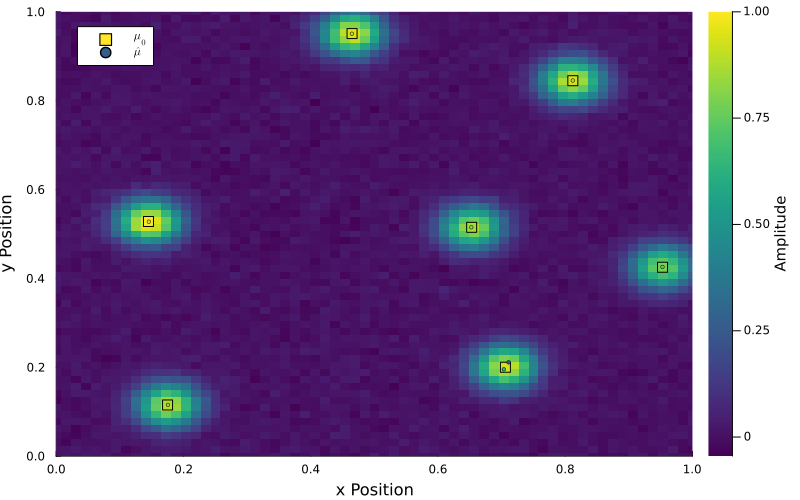

In [62]:
prob = BLASSO(y, ops, domain, λ)
solve!(prob, options=Dict(:maxits => length(a0) + 3, :descent => :smooth, :positivity => false))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)

Smooth bilevel inner

| Iteration | Lasso time | Lasso gc  | Lasso compile | LD time  | LD gc   | LD compile  |
|-----------|------------|-----------|---------------|----------|---------|-------------|
| 1         | 0.0642     | 0.0167    | 0.0           | 0.017    | 0.0028  | 0.0         |
| 2         | 0.1904     | 0.0469    | 0.0           | 0.0758   | 0.0111  | 0.0         |
| 3         | 0.1049     | 0.0235    | 0.0           | 0.1984   | 0.0292  | 0.0         |
| 4         | 0.1159     | 0.0263    | 0.0           | 0.3602   | 0.0592  | 0.0         |
| 5         | 0.1717     | 0.0389    | 0.0           | 0.577    | 0.0834  | 0.0         |
| 6         | 0.3866     | 0.0838    | 0.0           | 0.9739   | 0.1237  | 0.0         |
| 7         | 0.3568     | 0.0741    | 0.0           | 1.5448   | 0.1931  | 0.0         |
| 8         | 0.1791     | 0.0381    | 0.0           | 5.7886   | 0.6973  | 0.0         |


DiscreteMeasure([[0.7109374999997605, 0.14559081474654575, 0.8119145030731603, 0.4646545815377098, 0.6524230631177861, 0.1756647031768009, 0.9528756752899792, 0.7034908092091072], [0.21093749999992434, 0.5275720912991188, 0.8453625414499233, 0.9506278788398428, 0.5149020788244673, 0.11541604809768613, 0.4257355701252594, 0.19531250000000017]], [0.25491356350931144, 0.9444642598766474, 0.8784414353656551, 0.8936487422088089, 0.8082221022558405, 0.826103348390089, 0.7368229532694865, 0.6159653345879471], 2, 8)

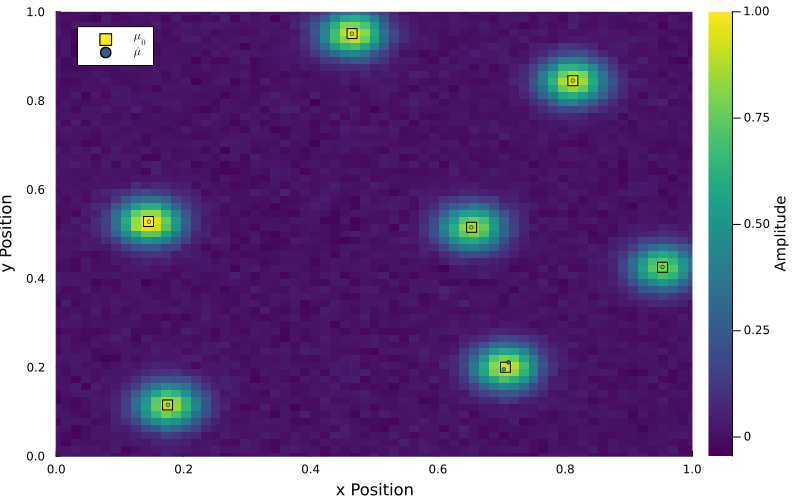

In [56]:
prob = BLASSO(y, ops, domain, λ)
solve!(prob, options=Dict(:maxits => length(a0) + 3, :descent => :smooth_inner, :positivity => false))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)